In [1]:
"""Train a latent SDE on data from a stochastic Lorenz attractor.

Reproduce the toy example in Section 7.2 of https://arxiv.org/pdf/2001.01328.pdf

To run this file, first run the following to install extra requirements:
pip install fire

To run, execute:
python -m examples.latent_sde_lorenz
"""
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from typing import Sequence

import fire
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal
import src as ddfa_node

import torchsde
%matplotlib inline

In [2]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class StochasticLorenz(object):
    """Stochastic Lorenz attractor.

    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        # self.gru = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out

class LatentSDE(nn.Module):
    sde_type = "stratonovich"
    noise_type = "diagonal"

    def __init__(self, data_size, latent_size, context_size, hidden_size):
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=True, method="euler"):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1e-2, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1e-2, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1e-2, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs

In [4]:
def make_dataset(t0, t1, batch_size, noise_std, train_dir, device):
    data_path = os.path.join(train_dir, 'lorenz_data.pth')
    if os.path.exists(data_path):
        data_dict = torch.load(data_path)
        xs, ts = data_dict['xs'], data_dict['ts']
        logging.warning(f'Loaded toy data at: {data_path}')
        if xs.shape[1] != batch_size:
            raise ValueError("Batch size has changed; please delete and regenerate the data.")
        if ts[0] != t0 or ts[-1] != t1:
            raise ValueError("Times interval [t0, t1] has changed; please delete and regenerate the data.")
    else:
        _y0 = torch.randn(batch_size, 3, device=device)
        ts = torch.linspace(t0, t1, steps=100, device=device)
        xs = StochasticLorenz().sample(_y0, ts, noise_std, normalize=True)

        os.makedirs(os.path.dirname(data_path), exist_ok=True)
        torch.save({'xs': xs, 'ts': ts}, data_path)
        logging.warning(f'Stored toy data at: {data_path}')
    return xs, ts

In [5]:
def vis(xs, ts, latent_sde, bm_vis, img_path, num_samples=20):
    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 2)
    ax00 = fig.add_subplot(gs[0, 0]) #, projection='3d')
    ax01 = fig.add_subplot(gs[0, 1]) #, projection='3d')

    # Left plot: data.
    z1 = xs.cpu().numpy()[:, :, 0:1]
    z2 = xs.cpu().numpy()[:, :, 1:2]
    # z3 = xs.cpu().numpy()[:, :, 2:3]
    [ax00.plot(z1[:, i*5, 0], z2[:, i*5, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    # ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    # ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    # zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1 = xs[:, :, 0:1]
    z2 = xs[:, :, 1:2]
    # z3 = xs[:, :, 2:3]

    [ax01.plot(z1[:, i, 0], z2[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    # ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    # ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    # ax01.set_zlim(zlim)

    plt.savefig(img_path)
    plt.close()

In [8]:
def main(
        batch_size=800,
        latent_size=16,
        context_size=64,
        hidden_size=32,
        lr_init=0.005,
        t0=0.,
        t1=2.,
        lr_gamma=0.9999,
        num_iters=15000,
        kl_anneal_iters=4000,
        pause_every=100,
        noise_std=0.005,
        adjoint=False,
        train_dir='./torchsde/vdp/',
        timesteps_per_sample = 3000,
        method="reversible_heun",
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # xs, ts = make_dataset(t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std, train_dir=train_dir, device=device)
    data = np.load("/home/michael/Synology/Julia/data/VDP_SDEs.npy")
    # time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
    τ, k = 12, 4
    # xs = ddfa_node.change_trial_length(ddfa_node.takens_embedding(data, tau=τ, k=k), timesteps_per_subsample=timesteps_per_sample, skip=timesteps_per_sample).swapaxes(0, 1)
    xs = ddfa_node.change_trial_length(data, timesteps_per_subsample=timesteps_per_sample, skip=timesteps_per_sample).swapaxes(0, 1)
    print(xs.shape)
    xs = torch.from_numpy(xs).float().to(device)
    ts = torch.linspace(t0, t1, xs.shape[0]).float().to(device)
    
    latent_sde = LatentSDE(
        data_size=xs.shape[-1],
        latent_size=latent_size,
        context_size=context_size,
        hidden_size=hidden_size,
    ).to(device)
    optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_gamma)
    kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

    # Fix the same Brownian motion for visualization.
    bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=t1, size=(batch_size, latent_size,), device=device, levy_area_approximation="space-time")
        # t0=t0, t1=t1, size=(timesteps_per_sample, latent_size,), device=device, levy_area_approximation="space-time")


    for global_step in tqdm.tqdm(range(1, num_iters + 1)):
        try:
            latent_sde.zero_grad()
            log_pxs, log_ratio = latent_sde(xs, ts, noise_std, adjoint, method)
            loss = -log_pxs + log_ratio * kl_scheduler.val
            loss.backward()
            optimizer.step()
            scheduler.step()
            kl_scheduler.step()
    
            if global_step % pause_every == 0:
                lr_now = optimizer.param_groups[0]['lr']
                logging.warning(
                    f'global_step: {global_step:06d}, lr: {lr_now:.5f}, '
                    f'log_pxs: {log_pxs:.4f}, log_ratio: {log_ratio:.4f} loss: {loss:.4f}, kl_coeff: {kl_scheduler.val:.4f}'
                )
                img_path = os.path.join(train_dir, f'global_step_{global_step:06d}.pdf')
                vis(xs, ts, latent_sde, bm_vis, img_path)
        except Exception as e:
            print(e)
    return latent_sde

In [ ]:
model = main()

(3000, 800, 2)


  5%|▍         | 745/15000 [1:40:19<49:10:31, 12.42s/it]

In [9]:
# t0 = 0.0; t1 = 8.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = np.load("/home/michael/Synology/Julia/data/VDP_SDEs.npy")
# xs = ddfa_node.change_trial_length(data, timesteps_per_subsample=500, skip=500).swapaxes(0, 1)
xs = data.swapaxes(0, 1)
xs = torch.from_numpy(xs).float().to(device)
ts = torch.linspace(t0, t1*2, xs.shape[0]*2).float().to(device)
latent_size = 16
bm_vis = torchsde.BrownianInterval(t0=t0, t1=t1*2, size=(xs.shape[1], latent_size,), device=device, levy_area_approximation="space-time")
xs = model.sample(batch_size=xs.shape[1], ts=ts, bm=bm_vis).cpu().numpy()

In [10]:
xs.shape

(50000, 100, 2)

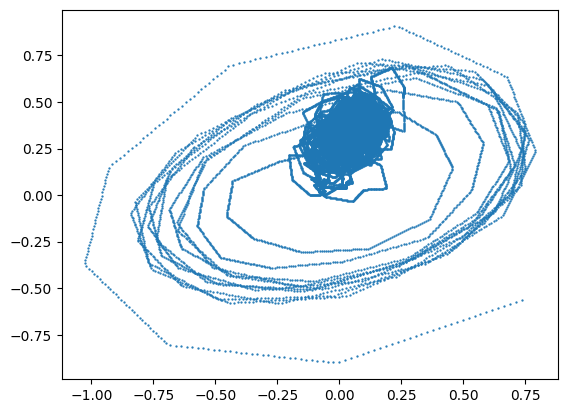

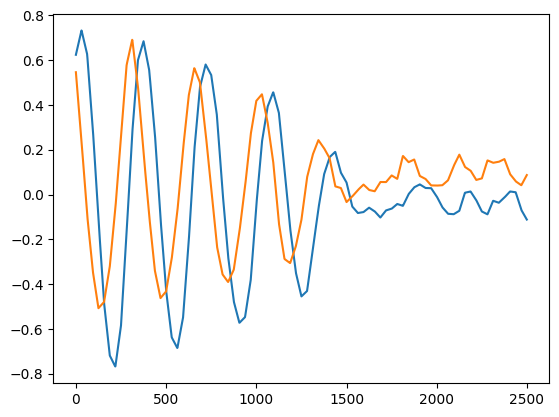

In [16]:
trial = 20
plt.scatter(xs[:, trial, 0], xs[:, trial, 1], s=0.4)
plt.show()
plt.figure()
plt.plot(xs[2500:5000, trial, :])

In [53]:
np.save("/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/data/VDP_gen_data_sde.npy", xs[1000:, :, :].swapaxes(0, 1))
